In [1]:
import astropy.units as u
import astropy.constants as c
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import sys 
sys.path.append('/Users/clairewilliams/opt/anaconda3/lib/python3.9/site-packages')
sys.path.append('../model-timescales/src')
import pandas
from timescales.data import build_bulk_energy_grid
from timescales import TimescaleEnsemble
from timescales.analysis.model import create_dynamical_model, create_dynamical_model_integral

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(71,0.27,Ob0=0.044, Tcmb0=2.726 *u.K)

In [2]:
masses_array   = np.logspace(4, 8, 10) * u.Msun
radii_array    = np.logspace(-0.7, 2, 10) * u.pc
velocity_array = np.logspace(-0.7, 2.2, 10) * u.km/u.s

grid = build_bulk_energy_grid(masses_array, radii_array, velocity_array,
                              alpha=3/5, energy_unit=u.erg)


# Example: access aligned arrays
M = grid['M']   # Msun
R = grid['R']   # pc
V = grid['V']   # km/s
K = grid['K']   # erg
U = grid['U']   # erg

print(len(M), len(R), len(V), len(K), len(U))  # -> 1_000_000 each (100*100*100

167 167 167 167 167


In [3]:
model = TimescaleEnsemble(grid, 
                    densityModel="power-law",
                    timescales_kwargs={'cosmology':cosmo},
                    profile_kwargs={"alpha":1.75})

Using power-law model with properties:
alpha=1.75
Using parameters for timescale evaluation
cosmology=FlatLambdaCDM(H0=71.0 km / (Mpc s), Om0=0.27, Tcmb0=2.726 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.044)
No imf arguments given. Defaulting to 'salpeter'.


In [16]:
mass_fraction_retained = 0.01
z_final = 10
results =  create_dynamical_model_integral(model, 
                            z_final=z_final,
                            mass_fraction_retained=mass_fraction_retained)

will use defaults for  {'e': 0.0, 'Mcollisions': <Quantity 1. solMass>, 'n_unit': <Quantity 1. 1 / cm3>, 'v_unit': Unit("cm / s"), 'Mstar_unit': Unit("solMass")}
Selected coulomb function based on BH or not.
will use defaults for  {'v_unit': Unit("km / s"), 'rho_unit': Unit("g / cm3"), 'mass_unit': Unit("solMass")}
Selected coulomb function based on BH or not.
will use defaults for  {'M_obj': <Quantity 10. solMass>, 'v_unit': Unit("km / s"), 'rho_unit': Unit("g / cm3"), 'mass_unit': Unit("solMass")}
Using default z = 12 since no redshift provided
Using nearest neighbor for interaction type.


/Users/clairewilliams/Research/Calculations/timescale-plots/../model-timescales/src/timescales/physics/halo_environment.py:135: RuntimeWarning: invalid value encountered in divide
  normalization_offset = stfunction17/stfunction


collisions occur in 159 systems
mass loss occurs in 0 systems


In [18]:
#here we're rescaling the objects based on whether over 50 % gets used
sys_type =np.zeros(model.Nsystems)
results['Mfinal'] = np.zeros(model.Nsystems)*u.Msun
for sys_id in range(model.Nsystems):
    if 1*u.Msun * results['N_collisions'][sys_id]>0.5*results['mass'][sys_id]:
        sys_type[sys_id] = 2
        frac_ml_collisions = results['N_collisions_massloss'][sys_id]/results['N_collisions'][sys_id]
        if frac_ml_collisions<=0.5:
            results['M_superstar'][sys_id]= 0.5*results['mass'][sys_id]*mass_fraction_retained
            results['Mgas'][sys_id] = 0.5*results['mass'][sys_id]*(1-mass_fraction_retained)
            results['Mfinal'][sys_id]= 0.5*results['mass'][sys_id]
    else:
        sys_type[sys_id]= 3
        results['Mfinal'][sys_id] = results['mass'][sys_id]-results['Mgas'][sys_id]-results['M_superstar'][sys_id]



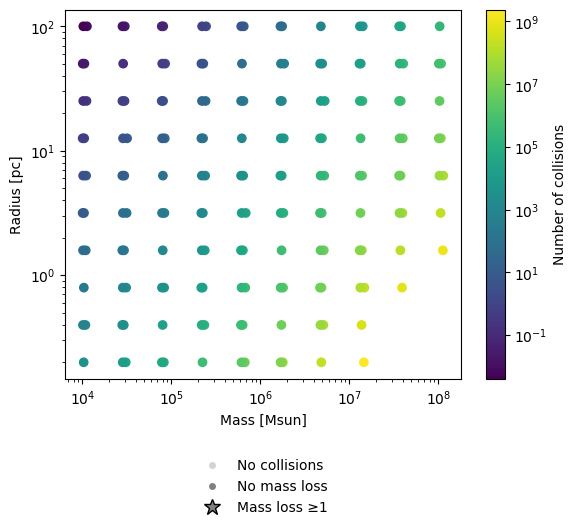

In [5]:
vratio = np.array([-results['potential'][i]/results['kinetic'][i] for i in range(len(results['potential']))])
x = np.array([results['mass'][i].value+(results['mass'][i].value *0.01 * vratio[i]) for i in range(len(vratio))]) * u.Msun
y = results['radius'] *u.pc
c = np.array(results['N_collisions'])
mflag = np.array(results['N_collisions_massloss'])  # new flag array

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

# Mask zeros for log-scaling
c_masked = np.ma.masked_equal(c, 0)
norm = mcolors.LogNorm(vmin=c_masked.min(), vmax=c_masked.max())
cmap = plt.cm.viridis

# --- Separate the two populations by shape ---
mask_star = mflag >= 1   # star markers
mask_circle = ~mask_star # circle markers

# Plot circles (no mass loss)
sc1 = ax.scatter(x[mask_circle], y[mask_circle], 
                 c=np.ma.masked_equal(c[mask_circle], 0), 
                 cmap=cmap, norm=norm, marker='o')

# Plot stars (mass loss ≥1)
sc2 = ax.scatter(x[mask_star], y[mask_star], 
                 c=np.ma.masked_equal(c[mask_star], 0), 
                 cmap=cmap, norm=norm, marker='*', s=120, edgecolor='k')

# Add explicit grey points for zeros
ax.scatter(x[c == 0], y[c == 0], color="lightgrey", marker='o', alpha=0.7, label="0 collisions")

# --- Colorbar ---
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.set_label("Number of collisions")

# Add legend for shapes
legend_handles = [
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='lightgrey',
               label='No collisions'),
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='gray',
               label='No mass loss'),
    plt.Line2D([], [], marker='*', color='w', markerfacecolor='gray',
               markeredgecolor='k', markersize=12, label='Mass loss ≥1')
]

ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.4),
    frameon=False
)
ax.set_xlabel("Mass [Msun]")
ax.set_ylabel("Radius [pc]")

plt.show()

In [19]:
# Objects distinguished by outcome

In [ ]:
vratio = np.array([-results['potential'][i]/results['kinetic'][i] for i in range(len(results['potential']))])
x = np.array([results['mass'][i].value+(results['mass'][i].value *0.01 * vratio[i]) for i in range(len(vratio))]) * u.Msun
y = results['radius'] *u.pc
c = np.array(results['minimum_disruption_time']*u.yr)
mflag = np.array(results['which_disruption_time'])  # new flag array

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

# Mask zeros for log-scaling
c_masked = np.ma.masked_equal(c, 0)
norm = mcolors.LogNorm(vmin=c_masked.min(), vmax=c_masked.max())
cmap = plt.cm.viridis

# --- Separate the two populations by shape ---
mask_star = mflag >= 1   # star markers
mask_circle = ~mask_star # circle markers

# Plot circles (no mass loss)
sc1 = ax.scatter(x[mask_circle], y[mask_circle], 
                 c=np.ma.masked_equal(c[mask_circle], 0), 
                 cmap=cmap, norm=norm, marker='o')

# Plot stars (mass loss ≥1)
sc2 = ax.scatter(x[mask_star], y[mask_star], 
                 c=np.ma.masked_equal(c[mask_star], 0), 
                 cmap=cmap, norm=norm, marker='*', s=120, edgecolor='k')

# Add explicit grey points for zeros
ax.scatter(x[c == 0], y[c == 0], color="lightgrey", marker='o', alpha=0.7, label="0 collisions")

# --- Colorbar ---
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.set_label("Number of collisions")

# Add legend for shapes
legend_handles = [
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='lightgrey',
               label='No collisions'),
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='gray',
               label='No mass loss'),
    plt.Line2D([], [], marker='*', color='w', markerfacecolor='gray',
               markeredgecolor='k', markersize=12, label='Mass loss ≥1')
]

ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.4),
    frameon=False
)
ax.set_xlabel("Mass [Msun]")
ax.set_ylabel("Radius [pc]")

plt.show()

array([3.17791903e+03, 1.28785988e+03, 6.13266713e+02, 2.47008711e+02,
       9.83497605e+01, 4.68329560e+01, 1.82403048e+01, 8.68580910e+00,
       6.81424527e+00, 3.24485741e+00, 1.12407858e+00, 5.35271986e-01,
       3.43153598e-01, 1.63405379e-01, 4.14063639e-02, 1.97171837e-02,
       8.34652588e-03, 3.97450936e-03, 2.46054729e+04, 1.17172345e+04,
       4.74830144e+03, 2.26114959e+03, 1.91249874e+03, 9.10712869e+02,
       3.62610570e+02, 1.72671389e+02, 1.41228056e+02, 6.72510654e+01,
       2.51237525e+01, 1.19636206e+01, 8.70333218e+00, 4.14441659e+00,
       1.26518850e+00, 6.02466731e-01, 1.52662993e-01, 3.07731825e-02,
       1.46537980e-02, 9.07222913e+04, 4.32076552e+04, 1.75072601e+04,
       7.05131900e+03, 3.35783487e+03, 1.33693185e+03, 5.20700576e+02,
       2.47952017e+02, 9.26299692e+01, 3.20887125e+01, 1.52802466e+01,
       4.66468110e+00, 2.22126300e+00, 1.18201411e+00, 5.62860128e-01,
       1.13459036e-01, 5.40277530e-02, 4.54690014e+05, 1.84475406e+05,
      

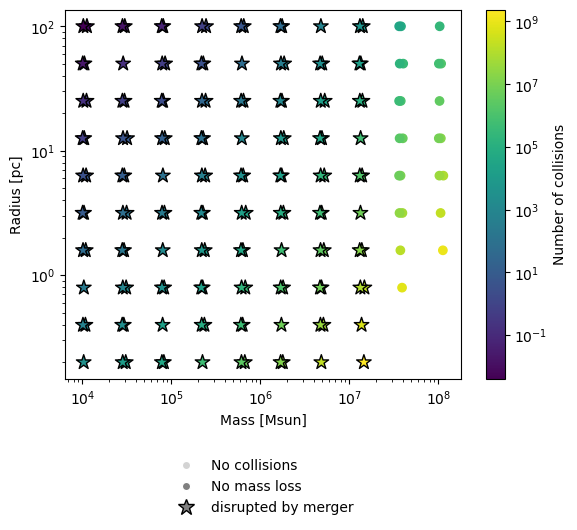

In [14]:
vratio = np.array([-results['potential'][i]/results['kinetic'][i] for i in range(len(results['potential']))])
x = np.array([results['mass'][i].value+(results['mass'][i].value *0.01 * vratio[i]) for i in range(len(vratio))]) * u.Msun
y = results['radius'] *u.pc
c = np.array(results['N_collisions'])
mflag = np.array(results['which_disruption_time'])

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

# Mask zeros for log-scaling
c_masked = np.ma.masked_equal(c, 0)
norm = mcolors.LogNorm(vmin=c_masked.min(), vmax=c_masked.max())
cmap = plt.cm.viridis

# --- Separate the two populations by shape ---
mask_star = mflag ==0   # star markers
mask_circle = ~mask_star # circle markers

# Plot circles (no mass loss)
sc1 = ax.scatter(x[mask_circle], y[mask_circle], 
                 c=np.ma.masked_equal(c[mask_circle], 0), 
                 cmap=cmap, norm=norm, marker='o')

# Plot stars (disrupted by merger)
sc2 = ax.scatter(x[mask_star], y[mask_star], 
                 c=np.ma.masked_equal(c[mask_star], 0), 
                 cmap=cmap, norm=norm, marker='*', s=120, edgecolor='k')

# --- Separate the two populations by shape ---
mask_star = mflag ==1   # star markers
mask_circle = ~mask_star # circle markers
# Plot stars (disrupted by merger)
sc2 = ax.scatter(x[mask_star], y[mask_star], 
                 c=np.ma.masked_equal(c[mask_star], 0), 
                 cmap=cmap, norm=norm, marker='D', s=120, edgecolor='k')
# Add explicit grey points for zeros
ax.scatter(x[c == 0], y[c == 0], color="lightgrey", marker='o', alpha=0.7, label="0 collisions")

# --- Colorbar ---
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.set_label("Number of collisions")

# Add legend for shapes
legend_handles = [
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='lightgrey',
               label='No collisions'),
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='gray',
               label='No mass loss'),
    plt.Line2D([], [], marker='*', color='w', markerfacecolor='gray',
               markeredgecolor='k', markersize=12, label='disrupted by merger')
]

ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.4),
    frameon=False
)
ax.set_xlabel("Mass [Msun]")
ax.set_ylabel("Radius [pc]")

plt.show()

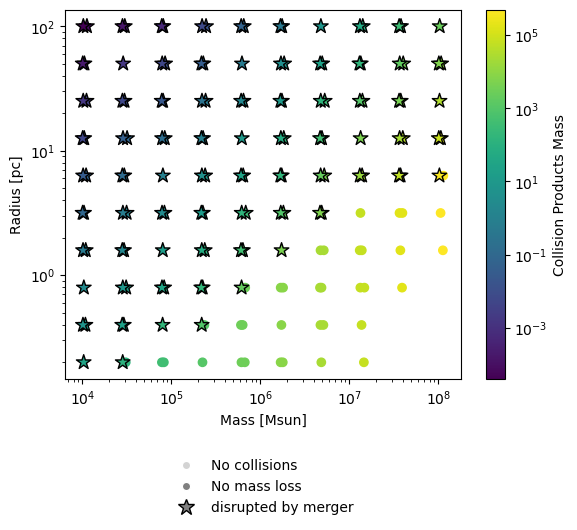

In [15]:
vratio = np.array([-results['potential'][i]/results['kinetic'][i] for i in range(len(results['potential']))])
x = np.array([results['mass'][i].value+(results['mass'][i].value *0.01 * vratio[i]) for i in range(len(vratio))]) * u.Msun
y = results['radius'] *u.pc
c = np.array(results['M_superstar'])
mflag = np.array(sys_type)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

# Mask zeros for log-scaling
c_masked = np.ma.masked_equal(c, 0)
norm = mcolors.LogNorm(vmin=c_masked.min(), vmax=c_masked.max())
cmap = plt.cm.viridis

# --- Separate the two populations by shape ---
mask_star = mflag >=3   # star markers
mask_circle = ~mask_star # circle markers

# Plot circles (no mass loss)
sc1 = ax.scatter(x[mask_circle], y[mask_circle], 
                 c=np.ma.masked_equal(c[mask_circle], 0), 
                 cmap=cmap, norm=norm, marker='o')

# Plot stars (disrupted by merger)
sc2 = ax.scatter(x[mask_star], y[mask_star], 
                 c=np.ma.masked_equal(c[mask_star], 0), 
                 cmap=cmap, norm=norm, marker='*', s=120, edgecolor='k')

# --- Separate the two populations by shape ---
mask_star = mflag ==1   # star markers
mask_circle = ~mask_star # circle markers
# Plot stars (disrupted by merger)
sc2 = ax.scatter(x[mask_star], y[mask_star], 
                 c=np.ma.masked_equal(c[mask_star], 0), 
                 cmap=cmap, norm=norm, marker='D', s=120, edgecolor='k')
# Add explicit grey points for zeros
ax.scatter(x[c == 0], y[c == 0], color="lightgrey", marker='o', alpha=0.7, label="0 collisions")

# --- Colorbar ---
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.set_label("Collision Products Mass")

# Add legend for shapes
legend_handles = [
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='lightgrey',
               label='No collisions'),
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='gray',
               label='No mass loss'),
    plt.Line2D([], [], marker='*', color='w', markerfacecolor='gray',
               markeredgecolor='k', markersize=12, label='disrupted by merger')
]

ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.4),
    frameon=False
)
ax.set_xlabel("Mass [Msun]")
ax.set_ylabel("Radius [pc]")

plt.show()

In [7]:
c = np.array(results['M_superstar'])
